# Lunar Lander - PPO

In [2]:
import os
import time
from abc import ABC, abstractmethod
from enum import Enum
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple

from IPython.display import clear_output

%pip install swig
%pip install "gymnasium[box2d]"

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Agent-related Class Definitions

In [4]:
class PPONet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPONet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

class PPOAgent:
    BATCH_SIZE = 32
    CLIP_PARAM = 0.2
    GAMMA = 0.99
    LR = 1e-4
    GAE_LAMBDA = 0.95
    PPO_EPOCHS = 10
    VALUE_LOSS_COEF = 0.5
    ENTROPY_COEF = 0.01

    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = PPONet(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = []
        self.clip = self.CLIP_PARAM

    def store_transition(self, state, action, reward, next_state, done, log_prob, value):
        self.memory.append((state, action, reward, next_state, done, log_prob, value))

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        logits, value = self.policy_net(state_tensor)
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)
        action = torch.multinomial(probs, 1).item()
        log_prob = log_probs[0, action].item()
        
        return action, log_prob, value.item()

    def compute_gae(self, rewards, values, next_value, dones):
        advantages = []
        gae = 0
        values = values + [next_value]
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.GAMMA * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.GAMMA * self.GAE_LAMBDA * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32, device=self.device)
        returns = advantages + torch.tensor(values[:-1], dtype=torch.float32, device=self.device)
        
        return advantages, returns

    def step(self):
        if len(self.memory) < self.BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones, old_log_probs, old_values = zip(*self.memory)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32, device=self.device)
        old_values = torch.tensor(old_values, dtype=torch.float32, device=self.device)

        with torch.no_grad():
            _, next_value = self.policy_net(states[-1:])
        advantages, returns = self.compute_gae(rewards, old_values.tolist(), next_value.item(), dones)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.PPO_EPOCHS):
            logits, values = self.policy_net(states)
            probs = F.softmax(logits, dim=-1)
            log_probs = F.log_softmax(logits, dim=-1)
            selected_log_probs = log_probs[range(len(actions)), actions]

            ratios = torch.exp(selected_log_probs - old_log_probs)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(values.squeeze(), returns)
            entropy = -(probs * log_probs).sum(dim=-1).mean()

            loss = policy_loss + self.VALUE_LOSS_COEF * value_loss - self.ENTROPY_COEF * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.memory.clear()

## Training Function Definition

In [6]:
def train_ppo(env, training_episodes=1000, agent_class=PPOAgent):
    CONVERGENCE_REWARD_COUNT = 20
    CONVERGENCE_MIN_REWARD = 270
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = agent_class(state_dim, action_dim)
    rewards_per_episode = []
    steps_per_episode = []
    episode_times = []
    start_episode = 0
    early_stop_counter = 0

    for episode in range(training_episodes):
        start_time = time.time()
        obs, _ = env.reset()
        state = obs
        total_reward = 0
        done = False
        steps_taken = 0
        agent.memory = []

        while not done:
            action, log_prob, value = agent.select_action(state)
            obs, reward, done, _, _ = env.step(action)
            next_state = np.array(obs, dtype=np.float32)
            total_reward += reward
            steps_taken += 1

            agent.store_transition(state, action, reward, next_state, done, log_prob, value)
            state = next_state

        average_rewards_over_last_episodes = np.mean(rewards_per_episode[-CONVERGENCE_REWARD_COUNT:])
          
        if average_rewards_over_last_episodes >= CONVERGENCE_MIN_REWARD and total_reward >= CONVERGENCE_MIN_REWARD:
            print("Early stopping condition met! Stopping training.")
            print(f"Episode {episode + 1:}: Total Reward: {total_reward:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
            break
        
        agent.step()
        steps_per_episode.append(steps_taken)
        rewards_per_episode.append(total_reward)
        episode_time = time.time() - start_time
        episode_times.append(episode_time)

        if episode % 10 == 0:    
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
        if episode % 100 == 0:
            checkpoint = {
              'policy_net_state_dict': agent.policy_net.state_dict(),
              'optimizer_state_dict': agent.optimizer.state_dict(),
              'rewards_per_episode': rewards_per_episode,
              'episode_times': episode_times,
              'steps_per_episode': steps_per_episode
            }

            torch.save(checkpoint, "ppo_lunar_lander_v3_checkpoint.pth")
            torch.save(agent.policy_net.state_dict(), "ppo_lunar_lander_v3.pth")
            print("Checkpoint Reached!")
   
    return agent, rewards_per_episode, episode_times, steps_per_episode

## LunarLander-v3 - Training

In [8]:
env_name = "LunarLander-v3"
lunar_env = gym.make(env_name)

trained_agent, rewards_per_episode, episode_times, steps_per_episode = train_ppo(lunar_env, training_episodes = 1500)

checkpoint = {
    'policy_net_state_dict': trained_agent.policy_net.state_dict(),
    'optimizer_state_dict': trained_agent.optimizer.state_dict(),
    'rewards_per_episode': rewards_per_episode,
    'episode_times': episode_times,
    'steps_per_episode': steps_per_episode
}

torch.save(checkpoint, "ppo_lunar_lander_v3_checkpoint.pth")
torch.save(trained_agent.policy_net.state_dict(), "ppo_lunar_lander_v3.pth")

C:\Users\viswa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\viswa\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 1: Total Reward: -126.49720174999294, Steps: 77, Time: 0.08s
Checkpoint Reached!
Episode 11: Total Reward: -89.07287615965045, Steps: 107, Time: 0.09s
Episode 21: Total Reward: -142.69321460155874, Steps: 71, Time: 0.07s
Episode 31: Total Reward: -157.5224058493108, Steps: 108, Time: 0.08s
Episode 41: Total Reward: -394.64711041437005, Steps: 85, Time: 0.08s
Episode 51: Total Reward: -549.7562856817914, Steps: 79, Time: 0.07s
Episode 61: Total Reward: -314.4504359194983, Steps: 86, Time: 0.12s
Episode 71: Total Reward: -85.03354963969079, Steps: 79, Time: 0.07s
Episode 81: Total Reward: -89.47505682699477, Steps: 132, Time: 0.10s
Episode 91: Total Reward: -135.474737695516, Steps: 68, Time: 0.07s
Episode 101: Total Reward: -166.48394253186905, Steps: 108, Time: 0.10s
Checkpoint Reached!
Episode 111: Total Reward: -165.3259004946549, Steps: 80, Time: 0.07s
Episode 121: Total Reward: -473.4710660821102, Steps: 114, Time: 0.12s
Episode 131: Total Reward: -105.83180839548777, Steps

## Training Results

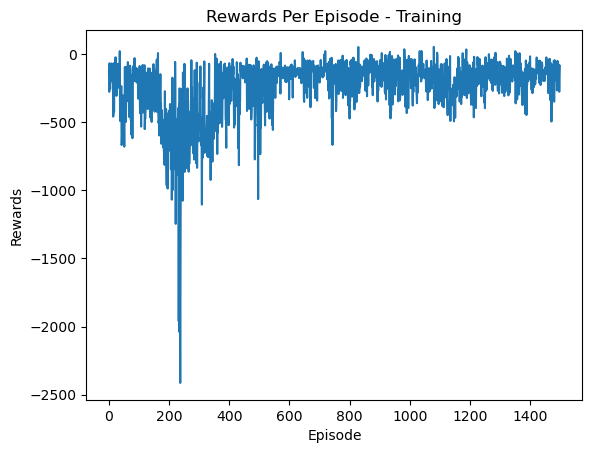

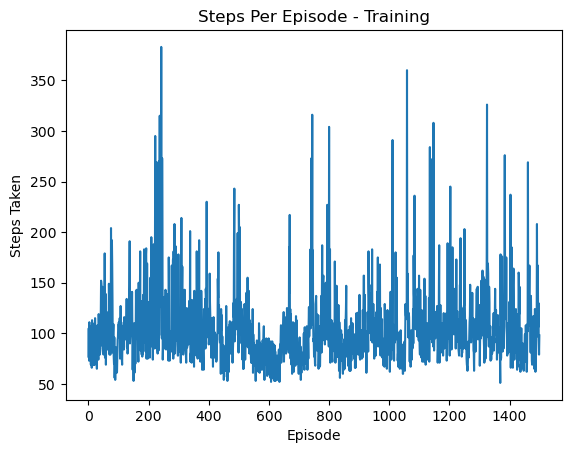

In [10]:
results = torch.load("ppo_lunar_lander_v3_checkpoint.pth", weights_only=False)

rewards_per_episode = results["rewards_per_episode"]
steps_per_episode = results["steps_per_episode"]

plt.plot(rewards_per_episode)
plt.title("Rewards Per Episode - Training")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

plt.plot(steps_per_episode)
plt.title("Steps Per Episode - Training")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.show()

## LunarLander-v3 - Evaluation

Episode 1: Total Reward = 42.477541021160924, Steps taken: 1000
Episode 2: Total Reward = -235.00946454230464, Steps taken: 106
Episode 3: Total Reward = -474.5364438161627, Steps taken: 228
Episode 4: Total Reward = -327.9099541747679, Steps taken: 118
Episode 5: Total Reward = -297.4363402967888, Steps taken: 120
Episode 6: Total Reward = -367.2085139042027, Steps taken: 148
Episode 7: Total Reward = -185.4955849670958, Steps taken: 127
Episode 8: Total Reward = -159.1413720191856, Steps taken: 120
Episode 9: Total Reward = -191.648586955616, Steps taken: 92
Episode 10: Total Reward = -373.7221822293384, Steps taken: 209

Average reward over 10 episodes: -256.9630901884301
Average steps taken over 10 episodes: 226.8



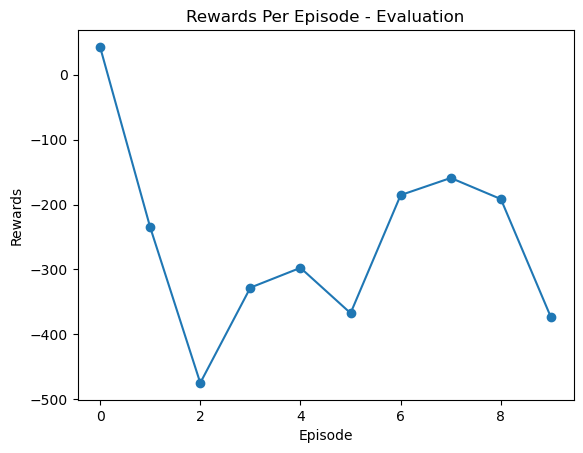

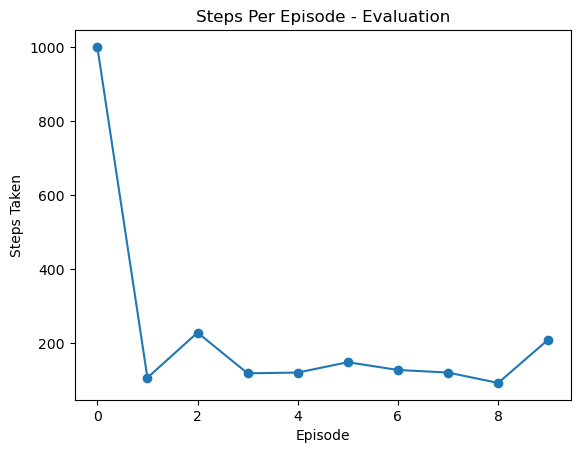

In [14]:
steps_arr = []
rewards_arr = []

env_name = "LunarLander-v3"
lunar_env = gym.make(env_name)

state_dim = lunar_env.observation_space.shape[0]
action_dim = lunar_env.action_space.n

trained_agent = PPOAgent(state_dim, action_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_agent.policy_net.load_state_dict(torch.load("ppo_lunar_lander_v3.pth", map_location=device, weights_only=True))

for episode in range(10):
    obs, _ = lunar_env.reset()
    state = obs
    tot_reward = 0
    episode_over = False
    steps_taken = 0
    
    while not episode_over:
        with torch.no_grad():
            action, _, _ = trained_agent.select_action(state)
        obs, reward, done, truncated, _ = lunar_env.step(action)
        episode_over = done or truncated
        state = np.array(obs, dtype=np.float32)
        steps_taken +=1
        tot_reward += reward
    rewards_arr.append(tot_reward)
    steps_arr.append(steps_taken)
    print(f"Episode {episode + 1}: Total Reward = {tot_reward}, Steps taken: {steps_taken}")

print(f"\nAverage reward over 10 episodes: {np.mean(rewards_arr)}")
print(f"Average steps taken over 10 episodes: {np.mean(steps_arr)}\n")

plt.plot(rewards_arr, marker="o")
plt.title("Rewards Per Episode - Evaluation")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

plt.plot(steps_arr, marker="o")
plt.title("Steps Per Episode - Evaluation")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.show()